# Natural Language Processing 

### Nehal Aggarwal 

### Ashish Verma 



### Mounting Google Drive

In [0]:
# Load the Drive helper and mount
from google.colab import drive

In [0]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pwd
%cd /content/drive/My Drive/Term5/NLP/Assignment2

/content/drive/My Drive/Term5/NLP/Assignment2
/content/drive/My Drive/Term5/NLP/Assignment2


#### Loading all required  paths

In [0]:
dataPath = '/content/drive/My Drive/Term5/NLP/Assignment2/Dataset'
outputPath = '/content/drive/My Drive/Term5/NLP/Assignment2/Output'
sick_train = dataPath + '/SICK_train.txt'
sick_test = dataPath + '/SICK_test.txt'
sick_test_annotated = dataPath + '/SICK_test_annotated.txt'
sick_val = dataPath + '/SICK_trial.txt'
glove_vectors_file = dataPath + '/glove.840B.300d.txt'
fasttext_vectors_file = dataPath + '/crawl-300d-2M.vec'

## Task 1 Text Classification

#### Loading embeddings

In [0]:
import io
import numpy as np

In [0]:
#http://nlp.stanford.edu/data/glove.840B.300d.zip
glove_embeddings = {}

print('Loading '+ glove_vectors_file)
with open(glove_vectors_file, 'r') as f:
  for line in f:
    values = line.split(' ')
    word = values[0]
    embedding = np.asarray(values[1:], dtype='float32')
    glove_embeddings[word] = embedding
        
print('Embeddings size: %d' % len(glove_embeddings))

Loading /content/drive/My Drive/Term5/NLP/Assignment2/Dataset/glove.840B.300d.txt
Embeddings size: 2196016


In [0]:
#https://fasttext.cc/docs/en/english-vectors.html
fasttext_embeddings = {}

print('Loading '+ fasttext_vectors_file)
fin = io.open(fasttext_vectors_file, 'r', encoding='utf-8', newline='\n', errors='ignore')
n, d = map(int, fin.readline().split())
for line in fin:
  tokens = line.rstrip().split(' ')
  word = tokens[0]
  embedding = np.asarray(tokens[1:], dtype='float32')
  fasttext_embeddings[word] = embedding

print('Embeddings size: %d' % len(fasttext_embeddings))

Loading /content/drive/My Drive/Term5/NLP/Assignment2/Dataset/crawl-300d-2M.vec
Embeddings size: 1999995


In [0]:
embedding_dim = 300

### Loading Dataset and Pre-processing

#### Helper Methods

In [0]:
import pandas as pd
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


##### Pre-processing Helper Methods

In [0]:
def readFile(fileName):
  filedata = pd.read_csv(fileName, delimiter='\t', header = None, skiprows=1)
  filedata.columns = ["pair_ID", "sentence_A", "sentence_B", "relatedness_score", "entailment_judgment"]
  return filedata

In [0]:
from keras.utils import np_utils, plot_model
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [0]:
def convertToCategorical(data):
  labels = np_utils.to_categorical(le.fit_transform(data["entailment_judgment"].values)).astype("int64")
  return labels

In [0]:
def convertSentencesToList(traindata, validdata):
  train_sentence1 = traindata['sentence_A'].values.tolist()
  train_sentence2 = traindata['sentence_B'].values.tolist()

  valid_sentence1 = validdata['sentence_A'].values.tolist()
  valid_sentence2 = validdata['sentence_B'].values.tolist()
  return train_sentence1, train_sentence2, valid_sentence1, valid_sentence2

In [0]:
def converToWordSequences(embeddinglength, training_data, t_s1, t_s2, v_s1, v_s2):
  tokenizer = Tokenizer(num_words = embeddinglength)
  tokenizer.fit_on_texts(training_data)

  t_s1_word_sequences = tokenizer.texts_to_sequences(t_s1)
  t_s2_word_sequences = tokenizer.texts_to_sequences(t_s2)

  v_s1_word_sequences = tokenizer.texts_to_sequences(v_s1)
  v_s2_word_sequences = tokenizer.texts_to_sequences(v_s2)
  return tokenizer, t_s1_word_sequences, t_s2_word_sequences, v_s1_word_sequences, v_s2_word_sequences


#### Dataset

In [0]:
train_data = readFile(sick_train)
valid_data = readFile(sick_val)
test_data = readFile(sick_test_annotated)

In [0]:
train_df_features = train_data[['sentence_A','sentence_B']]
valid_df_features = valid_data[['sentence_A','sentence_B']]
test_df_features = test_data[['sentence_A','sentence_B']]

In [0]:
train_labels = convertToCategorical(train_data)
valid_labels = convertToCategorical(valid_data)
test_labels = convertToCategorical(test_data)

In [0]:
train_sent1, train_sent2, valid_sent1, valid_sent2 = convertSentencesToList(train_data, valid_data)

#### Map to Word Vectors

In [0]:
glove_length = len(glove_embeddings)
fasttext_length = len(fasttext_embeddings)

print('Found '+ str(len(train_sent1)) + ' in training sentence 1')
#print('Found '+ str(len(train_sent2)) + ' in training sentence 2')

training_sent = train_sent1 + train_sent2
valid_sent = valid_sent1 + valid_sent2

tokenizer_g, t_s1_word_sequences_g, t_s2_word_sequences_g, v_s1_word_sequences_g, v_s2_word_sequences_g = converToWordSequences(glove_length, training_sent, train_sent1, train_sent2, valid_sent1, valid_sent2)
tokenizer_f, t_s1_word_sequences_f, t_s2_word_sequences_f, v_s1_word_sequences_f, v_s2_word_sequences_f = converToWordSequences(fasttext_length, training_sent, train_sent1, train_sent2, valid_sent1, valid_sent2)
word_index_g = tokenizer_g.word_index
word_index_f = tokenizer_f.word_index

print('Found '+str(len(word_index_g))+' unique tokens for glove sequencing.')
print('Found '+str(len(word_index_f))+' unique tokens for fasttext sequencing.')

Found 4500 in training sentence 1
Found 2184 unique tokens for glove sequencing.
Found 2184 unique tokens for fasttext sequencing.


#### Map to word embeddings

In [0]:
from collections import defaultdict

In [0]:
def useWordEmbeddings(word_index, NUM_WORDS, embeddings, sentence1_word_sequences, sentence2_word_sequences):
  words_len = min(NUM_WORDS, len(word_index))
  # word_embedding_matrix = np.zeros((words_len + 1, embedding_dim))
  word_embedding_matrix = np.random.random((words_len + 1, embedding_dim))
  k = 0
  for word, i in word_index.items():
    if i >= NUM_WORDS:
      continue
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
      word_embedding_matrix[i] = embedding_vector
      k += 1
    
  max_word_count_text = 0
  text_count = defaultdict(int)
  for sentence in sentence1_word_sequences:
    max_word_count_text = max(max_word_count_text, len(sentence))
    text_count[len(sentence)] += 1

  max_word_count_hypo = 0
  hypo_count = defaultdict(int)
  for sentence in sentence2_word_sequences:
    max_word_count_hypo = max(max_word_count_hypo, len(sentence))
    hypo_count[len(sentence)] += 1

  return text_count, hypo_count, word_embedding_matrix

In [0]:
text_count_g, hypo_count_g, word_embedding_matrix_g = useWordEmbeddings(word_index_g, glove_length, glove_embeddings, t_s1_word_sequences_g, t_s2_word_sequences_g)
text_count_f, hypo_count_f, word_embedding_matrix_f = useWordEmbeddings(word_index_f, fasttext_length, fasttext_embeddings, t_s1_word_sequences_f, t_s2_word_sequences_f)

In [0]:
##Print details

In [0]:
max_seq_length = 30

In [0]:
from keras.preprocessing.sequence import pad_sequences

In [0]:
def convertToPadSequences(sentence1_word_sequences, sentence2_word_sequences, valid_sentence1_word_sequences, valid_sentence2_word_sequences, max_seq_length):
  s1_data = pad_sequences(sentence1_word_sequences, maxlen = max_seq_length)
  s2_data = pad_sequences(sentence2_word_sequences, maxlen = max_seq_length)
  s1_dataValid = pad_sequences(valid_sentence1_word_sequences, maxlen = max_seq_length)
  s2_dataValid = pad_sequences(valid_sentence2_word_sequences, maxlen = max_seq_length)
  return s1_data, s2_data, s1_dataValid, s2_dataValid

In [0]:
def printSentenceInfo(s1_data, s2_data, labels):
  print('Shape of sentence1 tensor:', s1_data.shape)
  print('Shape of sentence2 tensor:', s2_data.shape)
  print('Shape of label tensor:', labels.shape)

In [0]:
s1_data_g, s2_data_g, s1_dataValid_g, s2_dataValid_g = convertToPadSequences(t_s1_word_sequences_g, t_s2_word_sequences_g, v_s1_word_sequences_g, v_s2_word_sequences_g, max_seq_length)

In [0]:
s1_data_f, s2_data_f, s1_dataValid_f, s2_dataValid_f = convertToPadSequences(t_s1_word_sequences_f, t_s2_word_sequences_f, v_s1_word_sequences_f, v_s2_word_sequences_f, max_seq_length)

In [0]:
train_labels = convertToCategorical(train_data)
valid_labels = convertToCategorical(valid_data)

In [0]:
printSentenceInfo(s1_data_g, s2_data_g, train_labels)

Shape of sentence1 tensor: (4500, 30)
Shape of sentence2 tensor: (4500, 30)
Shape of label tensor: (4500, 3)


In [0]:
printSentenceInfo(s1_data_f, s2_data_f, train_labels)

Shape of sentence1 tensor: (4500, 30)
Shape of sentence2 tensor: (4500, 30)
Shape of label tensor: (4500, 3)


#### Models Training Helper Methods

In [0]:
from keras.layers import LSTM, Embedding, concatenate, Dense, PReLU, Dropout, Activation, Conv1D, MaxPooling1D, Flatten, SimpleRNN
from keras.models import Sequential
from keras.initializers import Constant
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from IPython.display import Image
import time
import matplotlib.pyplot as plt

In [0]:
num_lstm = np.random.randint(175, 275)
num_dense = np.random.randint(100, 150)
rate_drop_lstm = 0.15 + np.random.rand() * 0.25
rate_drop_dense = 0.15 + np.random.rand() * 0.25

##### Training Helper Methods

In [0]:
batch_size = 32

In [0]:
def trainModel(model, model_name, s1_data, s2_data, labels, batch_size, s1_data_valid, s2_data_valid, labels_valid):
  checkpoint = ModelCheckpoint(model_name + '-checkpoint-weights.{epoch:02d}-{val_acc:.2f}.hdf5', monitor='val_acc', save_best_only=True)
  history = model.fit([s1_data, s2_data],
                        labels,
                        epochs = 30,
                        batch_size = batch_size,
                        validation_data=([s1_data_valid, s2_data_valid], labels_valid),
                        shuffle = False,
                        verbose = 2,
                        callbacks = [checkpoint])
  return history

In [0]:
def plotModelPicture(model, model_name):
  plot_model(model, to_file = outputPath+'/'+model_name + '-model.png', show_shapes=False)

In [0]:
def plotMetricsGraph(modelhistory, model_name):
  # summarize history for accuracy
  plt.plot(modelhistory.history['acc'])
  plt.plot(modelhistory.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  plt.savefig(model_name + '-acc.png', dpi = 300)

  # summarize history for loss
  plt.plot(modelhistory.history['loss'])
  plt.plot(modelhistory.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  plt.savefig(model_name + '-loss.png', dpi = 300)

#### Models

In [0]:
def LSTMModel(word_index, EMBEDDING_DIM, embedding_matrix, MAX_SEQUENCE_LENGTH, p_drop=0.0):
  
    lstm_layer = LSTM(num_lstm, dropout=rate_drop_lstm, recurrent_dropout=rate_drop_lstm)

  
    encoder_1 = Sequential()
    encoder_1.add(Embedding(len(word_index) + 1, EMBEDDING_DIM,
                                    embeddings_initializer=Constant(embedding_matrix),
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=False))


    encoder_1.add(lstm_layer)

    encoder_2 = Sequential()
    encoder_2.add(Embedding(len(word_index) + 1, EMBEDDING_DIM,
                                    embeddings_initializer=Constant(embedding_matrix),
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=False))



    encoder_2.add(lstm_layer)

    

    merged_layers = concatenate([encoder_1.output, encoder_2.output])
    
    x = BatchNormalization()(merged_layers)
    x = Dense(EMBEDDING_DIM)(x)
    x = PReLU()(x)
    x = Dropout(p_drop)(x)
    x = BatchNormalization()(x)
    x = Dense(EMBEDDING_DIM)(x)
    x = PReLU()(x)
    x = Dropout(p_drop)(x)
    x = BatchNormalization()(x)
    x = Dense(3)(x)

    out = Activation('softmax')(x)
    merged_model = Model([encoder_1.input, encoder_2.input], [out])
    merged_model.compile(loss = 'mean_squared_error', optimizer=Adam(lr=0.01), metrics = ['accuracy'])
    
    return merged_model

In [0]:
def CNNModel(word_index, EMBEDDING_DIM, embedding_matrix, MAX_SEQUENCE_LENGTH, p_drop=0.0):
  encoder_1 = Sequential()
  encoder_1.add(Embedding(len(word_index) + 1, EMBEDDING_DIM,
                                    embeddings_initializer=Constant(embedding_matrix),
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=False))



  encoder_1.add(Conv1D(128, kernel_size = 2, padding = "same"))
  encoder_1.add(MaxPooling1D(pool_size=2, padding="same"))
  encoder_1.add(Conv1D(64, kernel_size = 2, padding = "same"))
  encoder_1.add(MaxPooling1D(pool_size=2, padding='same'))
  encoder_1.add(Conv1D(64, kernel_size = 2, padding = "same"))
  encoder_1.add(MaxPooling1D(pool_size=2, padding='same'))
  encoder_1.add(Conv1D(32, kernel_size = 2, padding = "same"))
  encoder_1.add(MaxPooling1D(pool_size=2, padding='same'))
  encoder_1.add(Conv1D(32, kernel_size = 2, padding = "same"))
  encoder_1.add(MaxPooling1D(pool_size=2, padding='same'))
  encoder_1.add(Conv1D(16, kernel_size = 2, padding = "same"))
  encoder_1.add(MaxPooling1D(pool_size=2, padding='same'))
  encoder_1.add(Conv1D(16, kernel_size = 2, padding = "same"))
  encoder_1.add(MaxPooling1D(pool_size=2, padding='same'))
  encoder_1.add(Conv1D(8, kernel_size = 2, padding = "same"))
  encoder_1.add(MaxPooling1D(pool_size=2, padding='same'))
  encoder_1.add(Conv1D(8, kernel_size = 2, padding = "same"))
  encoder_1.add(MaxPooling1D(pool_size=2, padding='same'))

                  
                  
  encoder_2 = Sequential()
  encoder_2.add(Embedding(len(word_index) + 1, EMBEDDING_DIM,
                                    embeddings_initializer=Constant(embedding_matrix),
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=False))


  encoder_2.add(Conv1D(128, kernel_size = 2, padding = "same"))
  encoder_2.add(MaxPooling1D(pool_size=2, padding='same'))
  encoder_2.add(Conv1D(64, kernel_size = 2, padding = "same"))
  encoder_2.add(MaxPooling1D(pool_size=2, padding='same'))
  encoder_2.add(Conv1D(64, kernel_size = 2, padding = "same"))
  encoder_2.add(MaxPooling1D(pool_size=2, padding='same'))
  encoder_2.add(Conv1D(32, kernel_size = 2, padding = "same"))
  encoder_2.add(MaxPooling1D(pool_size=2, padding='same'))
  encoder_2.add(Conv1D(32, kernel_size = 2, padding = "same"))
  encoder_2.add(MaxPooling1D(pool_size=2, padding='same'))
  encoder_2.add(Conv1D(16, kernel_size = 2, padding = "same"))
  encoder_2.add(MaxPooling1D(pool_size=2, padding='same'))
  encoder_2.add(Conv1D(16, kernel_size = 2, padding = "same"))
  encoder_2.add(MaxPooling1D(pool_size=2, padding='same'))
  encoder_2.add(Conv1D(8, kernel_size = 2, padding = "same"))
  encoder_2.add(MaxPooling1D(pool_size=2, padding='same'))
  encoder_2.add(Conv1D(8, kernel_size = 2, padding = "same"))
  encoder_2.add(MaxPooling1D(pool_size=2, padding='same'))
                  
    

  merged_layers = concatenate([encoder_1.output, encoder_2.output])
    
  x = Flatten()(merged_layers)
  x = Dense(8, kernel_initializer='normal', activation='relu', name="final_den_1") (x)
  out = Dense(3, activation="softmax", name="final_output")(x)

                  
  merged_model = Model([encoder_1.input, encoder_2.input], [out])
  merged_model.compile(loss = 'categorical_crossentropy', optimizer=Adam(lr=0.001), metrics = ['accuracy'])
    
  return merged_model

In [0]:
def RNNModel(word_index, EMBEDDING_DIM, embedding_matrix, MAX_SEQUENCE_LENGTH, p_drop=0.0):
  lstm_layer = SimpleRNN(num_lstm, dropout=rate_drop_lstm, recurrent_dropout=rate_drop_lstm)

  
  encoder_1 = Sequential()
  encoder_1.add(Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                input_length=MAX_SEQUENCE_LENGTH))

  encoder_1.add(SimpleRNN(num_lstm, dropout=rate_drop_lstm, recurrent_dropout=rate_drop_lstm))

  encoder_2 = Sequential()
  encoder_2.add(Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                input_length=MAX_SEQUENCE_LENGTH))

  encoder_2.add(SimpleRNN(num_lstm, dropout=rate_drop_lstm, recurrent_dropout=rate_drop_lstm))

    

  merged_layers = concatenate([encoder_1.output, encoder_2.output])
    
  x = BatchNormalization()(merged_layers)
  x = Dense(EMBEDDING_DIM)(x)
  x = PReLU()(x)
  x = Dropout(p_drop)(x)
  x = BatchNormalization()(x)
  x = Dense(EMBEDDING_DIM)(x)
  x = PReLU()(x)
  x = Dropout(p_drop)(x)
  x = BatchNormalization()(x)
  x = Dense(3)(x)

  out = Activation('softmax')(x)
  merged_model = Model([encoder_1.input, encoder_2.input], [out])
  merged_model.compile(loss = 'categorical_crossentropy', optimizer=Adam(lr=0.05), metrics = ['accuracy'])
    
  return merged_model

##### LSTM Model

Using Glove Embeddings 

In [0]:
model_lstm_g = LSTMModel(word_index_g, embedding_dim, word_embedding_matrix_g, max_seq_length, p_drop=0.25)
model_lstm_g.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_1_input (InputLayer)  (None, 30)           0                                            
__________________________________________________________________________________________________
embedding_2_input (InputLayer)  (None, 30)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 30, 300)      655500      embedding_1_input[0][0]          
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 30, 300)      655500      embedd

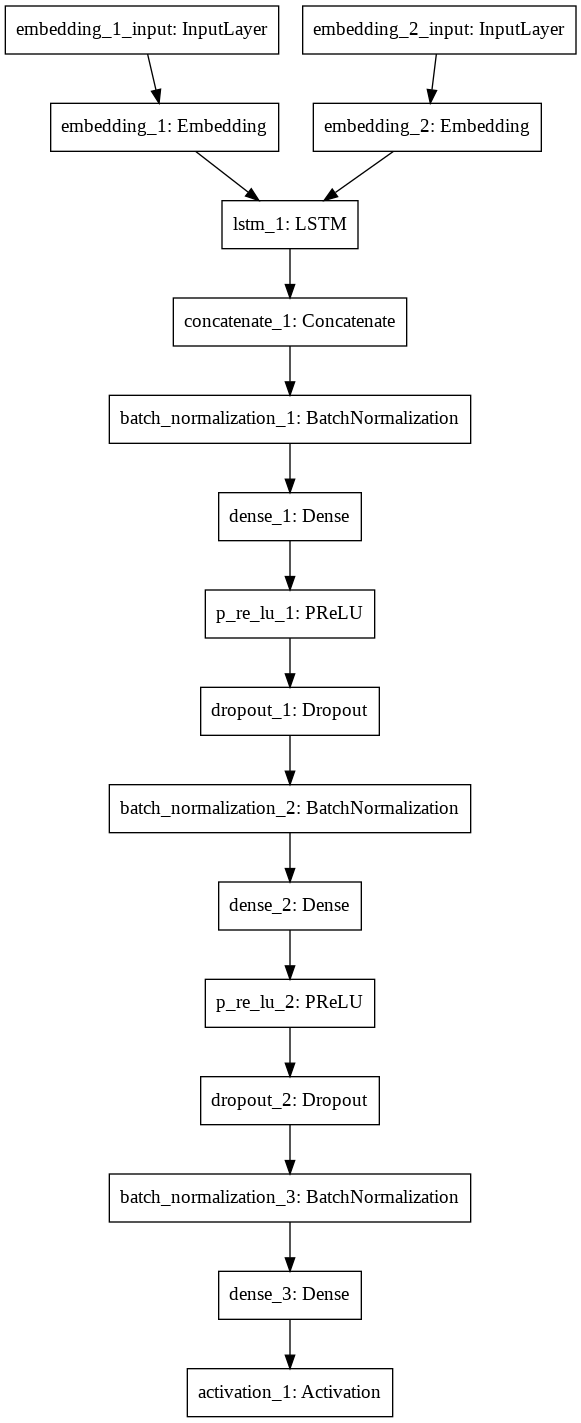

In [0]:
model_name = 'LSTM_Glove'
plotModelPicture(model_lstm_g, model_name)
Image(filename = outputPath+'/'+model_name + '-model.png')

In [0]:
history_lstm_g = trainModel(model_lstm_g, model_name, s1_data_g, s2_data_g, train_labels, batch_size, s1_dataValid_g, s2_dataValid_g, valid_labels)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 4500 samples, validate on 500 samples
Epoch 1/30





 - 30s - loss: 0.2419 - acc: 0.5071 - val_loss: 0.2301 - val_acc: 0.4980
Epoch 2/30
 - 27s - loss: 0.2060 - acc: 0.5471 - val_loss: 0.2525 - val_acc: 0.5200
Epoch 3/30
 - 27s - loss: 0.1923 - acc: 0.5698 - val_loss: 0.2291 - val_acc: 0.5560
Epoch 4/30
 - 27s - loss: 0.1731 - acc: 0.6107 - val_loss: 0.1861 - val_acc: 0.5340
Epoch 5/30
 - 27s - loss: 0.1671 - acc: 0.6138 - val_loss: 0.2056 - val_acc: 0.5680
Epoch 6/30
 - 27s - loss: 0.1574 - acc: 0.6442 - val_loss: 0.2043 - val_acc: 0.5640
Epoch 7/30
 - 27s - loss: 0.1541 - acc: 0.6509 - val_loss: 0.1632 - val_acc: 0.6400
Epoch 8/30
 - 27s - loss: 0.1464 - acc: 0.6680 - val_loss: 0.1944 - val_acc: 0.5720
Epoch 9/30
 - 27s - loss: 0.1478 - acc: 0.6653 - val_loss: 0.1760 - val_acc: 0.6020
Epoch 10/30
 - 27s - loss: 0.1436 - acc: 0.6771 - val_loss: 0.1778 - val_acc: 0.6120
Epoch 11/3

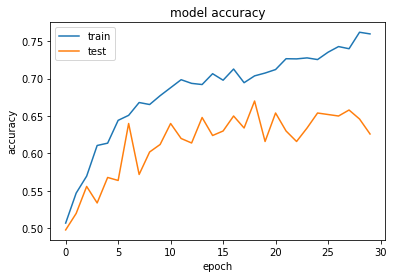

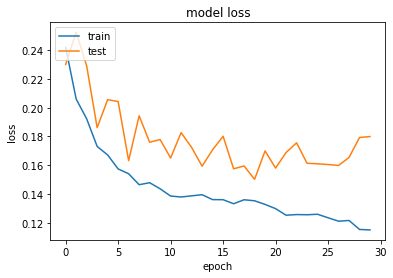

<Figure size 432x288 with 0 Axes>

In [0]:
plotMetricsGraph(history_lstm_g, model_name)

Using Fasttext Embeddings 

In [0]:
model_lstm_f = LSTMModel(word_index_f, embedding_dim, word_embedding_matrix_f, max_seq_length, p_drop=0.25)
model_lstm_f.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_3_input (InputLayer)  (None, 30)           0                                            
__________________________________________________________________________________________________
embedding_4_input (InputLayer)  (None, 30)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 30, 300)      655500      embedding_3_input[0][0]          
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 30, 300)      655500      embedding_4_input[0][0]          
____________________________________________________________________________________________

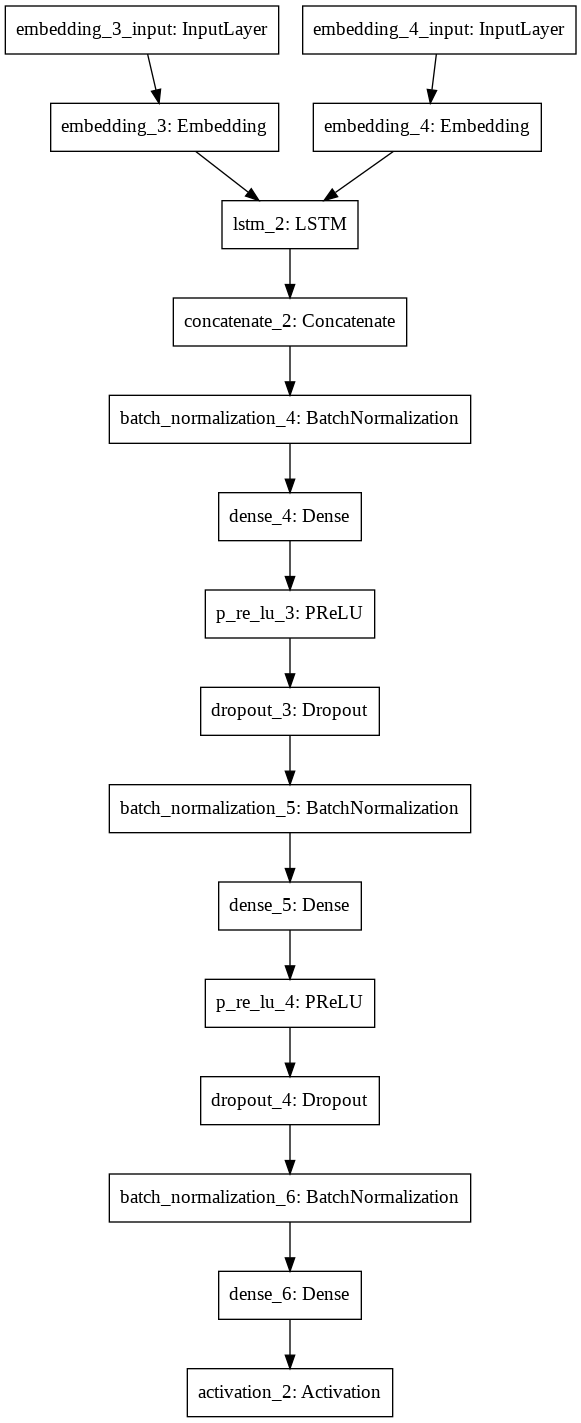

In [0]:
model_name = 'LSTM_Fasttext'
plotModelPicture(model_lstm_f, model_name)
Image(filename = outputPath+'/'+model_name + '-model.png')

In [0]:
history_lstm_f = trainModel(model_lstm_f, model_name, s1_data_f, s2_data_f, train_labels, batch_size, s1_dataValid_f, s2_dataValid_f, valid_labels)

Train on 4500 samples, validate on 500 samples
Epoch 1/30
 - 30s - loss: 0.2333 - acc: 0.5118 - val_loss: 0.2372 - val_acc: 0.5340
Epoch 2/30
 - 27s - loss: 0.2077 - acc: 0.5447 - val_loss: 0.2853 - val_acc: 0.5640
Epoch 3/30
 - 27s - loss: 0.1997 - acc: 0.5522 - val_loss: 0.2340 - val_acc: 0.5620
Epoch 4/30
 - 27s - loss: 0.1936 - acc: 0.5620 - val_loss: 0.2207 - val_acc: 0.4960
Epoch 5/30
 - 27s - loss: 0.1894 - acc: 0.5644 - val_loss: 0.3670 - val_acc: 0.2880
Epoch 6/30
 - 27s - loss: 0.1884 - acc: 0.5633 - val_loss: 0.2320 - val_acc: 0.4840
Epoch 7/30
 - 27s - loss: 0.1846 - acc: 0.5704 - val_loss: 0.2133 - val_acc: 0.5400
Epoch 8/30
 - 27s - loss: 0.1838 - acc: 0.5736 - val_loss: 0.2003 - val_acc: 0.5620
Epoch 9/30
 - 27s - loss: 0.1827 - acc: 0.5778 - val_loss: 0.1969 - val_acc: 0.5640
Epoch 10/30
 - 27s - loss: 0.1848 - acc: 0.5742 - val_loss: 0.2005 - val_acc: 0.5560
Epoch 11/30
 - 27s - loss: 0.1832 - acc: 0.5771 - val_loss: 0.2381 - val_acc: 0.3900
Epoch 12/30
 - 27s - loss: 

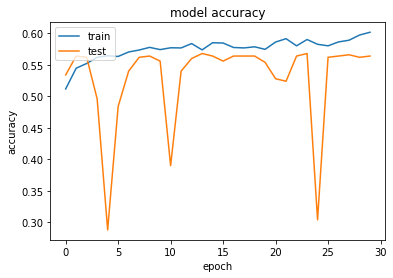

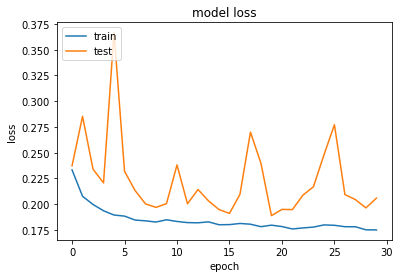

<Figure size 432x288 with 0 Axes>

In [0]:
plotMetricsGraph(history_lstm_f, model_name)

##### CNN Model

Using Glove Embeddings

In [0]:
model_cnn_g = CNNModel(word_index_g, embedding_dim, word_embedding_matrix_g, max_seq_length, p_drop=0.25)
model_cnn_g.summary()




Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_5_input (InputLayer)  (None, 30)           0                                            
__________________________________________________________________________________________________
embedding_6_input (InputLayer)  (None, 30)           0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 30, 300)      655500      embedding_5_input[0][0]          
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 30, 300)      655500      embedding_6_input[0][0]          
_________________________________________________________________________________________

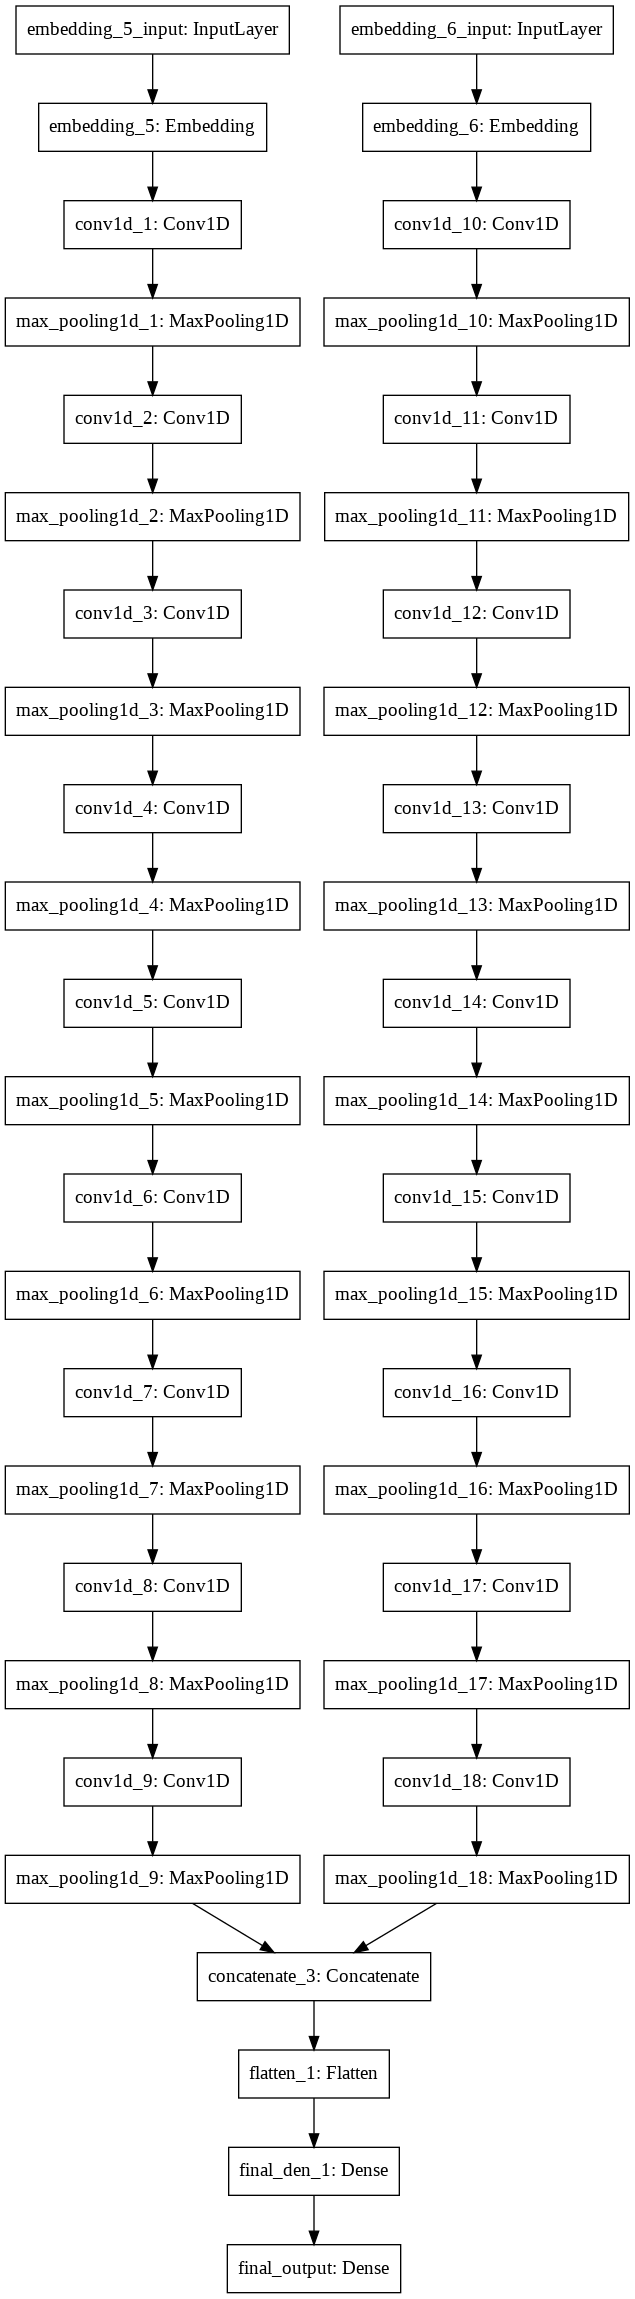

In [0]:
model_name = 'CNN_Glove'
plotModelPicture(model_cnn_g, model_name)
Image(filename = outputPath+'/'+model_name + '-model.png')

In [0]:
history_cnn_g = trainModel(model_cnn_g, model_name, s1_data_g, s2_data_g, train_labels, batch_size, s1_dataValid_g, s2_dataValid_g, valid_labels)

Train on 4500 samples, validate on 500 samples
Epoch 1/30
 - 13s - loss: 0.9739 - acc: 0.5611 - val_loss: 1.6969 - val_acc: 0.5640
Epoch 2/30
 - 4s - loss: 0.9756 - acc: 0.5636 - val_loss: 1.6486 - val_acc: 0.5640
Epoch 3/30
 - 4s - loss: 0.9709 - acc: 0.5636 - val_loss: 1.1689 - val_acc: 0.5640
Epoch 4/30
 - 4s - loss: 0.9512 - acc: 0.5636 - val_loss: 1.2540 - val_acc: 0.5640
Epoch 5/30
 - 4s - loss: 0.9309 - acc: 0.5553 - val_loss: 3.4945 - val_acc: 0.5640
Epoch 6/30
 - 4s - loss: 0.9109 - acc: 0.5744 - val_loss: 1.0809 - val_acc: 0.5800
Epoch 7/30
 - 5s - loss: 0.8645 - acc: 0.5787 - val_loss: 1.1680 - val_acc: 0.5600
Epoch 8/30
 - 5s - loss: 0.8059 - acc: 0.5869 - val_loss: 1.3576 - val_acc: 0.5720
Epoch 9/30
 - 5s - loss: 0.7515 - acc: 0.6078 - val_loss: 1.0279 - val_acc: 0.5720
Epoch 10/30
 - 5s - loss: 0.7081 - acc: 0.6396 - val_loss: 0.9131 - val_acc: 0.5900
Epoch 11/30
 - 5s - loss: 0.6788 - acc: 0.6451 - val_loss: 0.9455 - val_acc: 0.5800
Epoch 12/30
 - 5s - loss: 0.6258 - ac

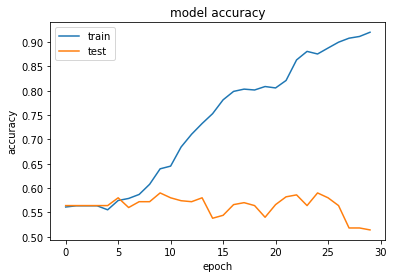

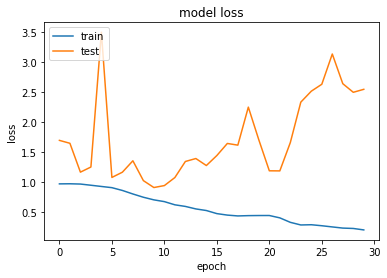

<Figure size 432x288 with 0 Axes>

In [0]:
plotMetricsGraph(history_cnn_g, model_name)

Using Fasttext Embeddings

In [0]:
model_cnn_f = CNNModel(word_index_f, embedding_dim, word_embedding_matrix_f, max_seq_length, p_drop=0.25)
model_cnn_f.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_7_input (InputLayer)  (None, 30)           0                                            
__________________________________________________________________________________________________
embedding_8_input (InputLayer)  (None, 30)           0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 30, 300)      655500      embedding_7_input[0][0]          
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 30, 300)      655500      embedding_8_input[0][0]          
____________________________________________________________________________________________

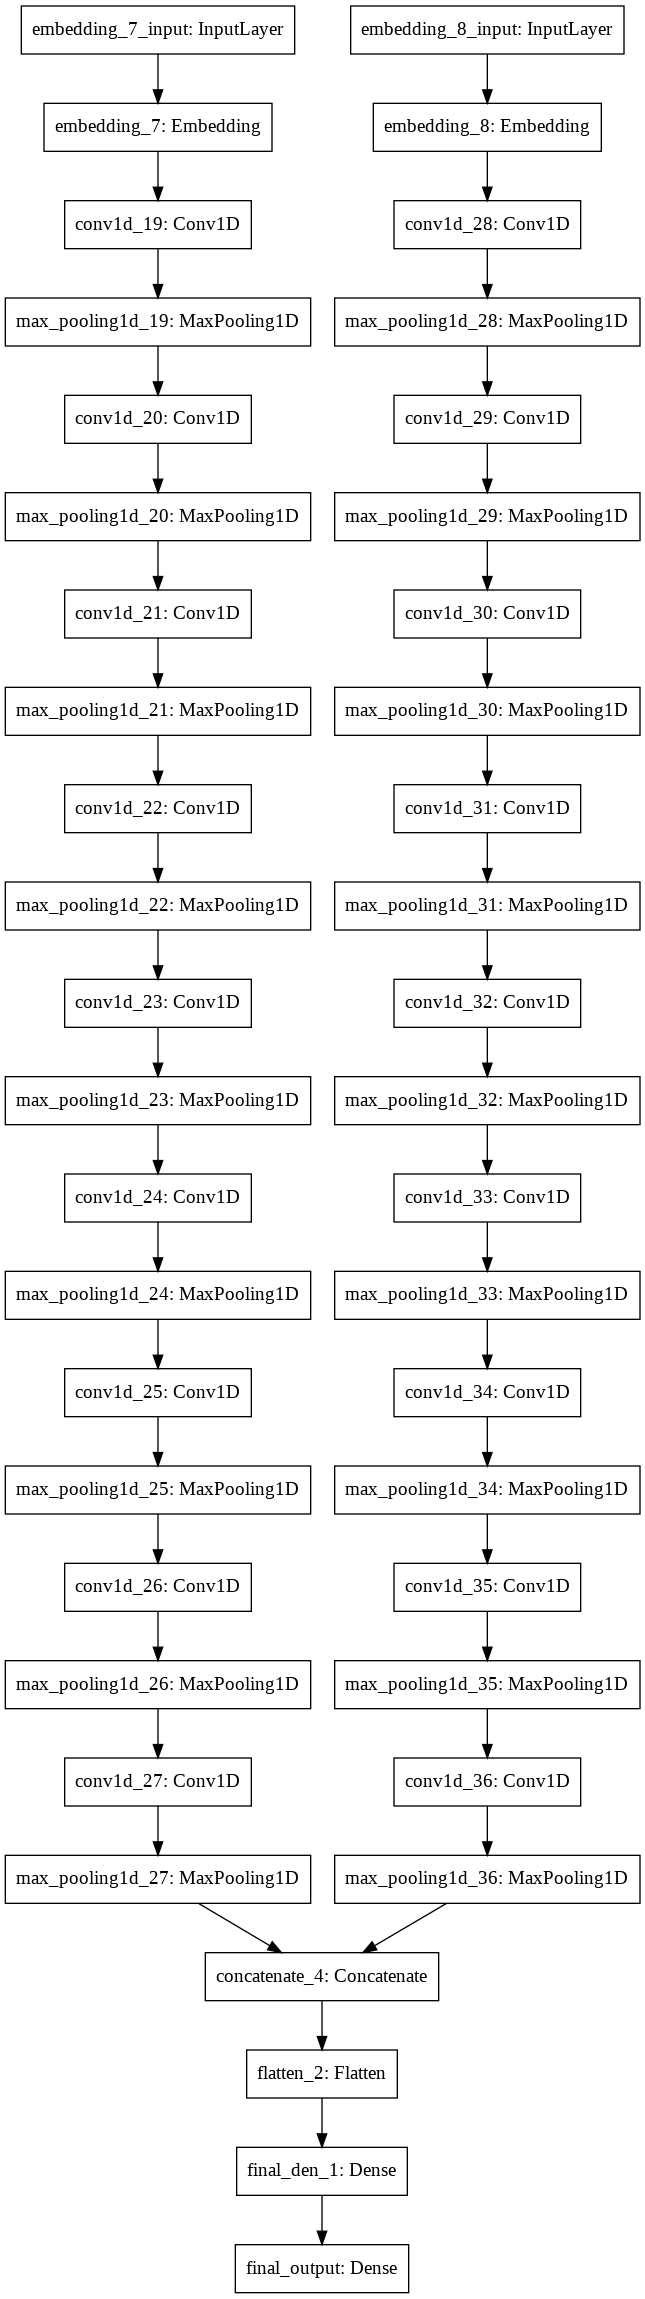

In [0]:
model_name = 'CNN_Fasttext'
plotModelPicture(model_cnn_f, model_name)
Image(filename = outputPath+'/'+model_name + '-model.png')

In [0]:
history_cnn_f = trainModel(model_cnn_f, model_name, s1_data_f, s2_data_f, train_labels, batch_size, s1_dataValid_f, s2_dataValid_f, valid_labels)

Train on 4500 samples, validate on 500 samples
Epoch 1/30
 - 7s - loss: 0.9698 - acc: 0.5571 - val_loss: 1.6329 - val_acc: 0.5640
Epoch 2/30
 - 5s - loss: 0.9757 - acc: 0.5636 - val_loss: 1.2440 - val_acc: 0.5640
Epoch 3/30
 - 5s - loss: 0.9630 - acc: 0.5633 - val_loss: 1.0669 - val_acc: 0.5640
Epoch 4/30
 - 5s - loss: 0.9352 - acc: 0.5633 - val_loss: 1.3434 - val_acc: 0.5640
Epoch 5/30
 - 5s - loss: 0.8957 - acc: 0.5727 - val_loss: 1.2523 - val_acc: 0.5740
Epoch 6/30
 - 5s - loss: 0.8782 - acc: 0.5731 - val_loss: 1.1374 - val_acc: 0.5820
Epoch 7/30
 - 5s - loss: 0.8263 - acc: 0.5773 - val_loss: 1.1328 - val_acc: 0.5700
Epoch 8/30
 - 5s - loss: 0.7417 - acc: 0.5924 - val_loss: 0.9436 - val_acc: 0.5880
Epoch 9/30
 - 5s - loss: 0.7051 - acc: 0.6140 - val_loss: 0.8266 - val_acc: 0.5960
Epoch 10/30
 - 5s - loss: 0.6688 - acc: 0.6253 - val_loss: 1.1806 - val_acc: 0.5680
Epoch 11/30
 - 5s - loss: 0.6374 - acc: 0.6469 - val_loss: 1.1478 - val_acc: 0.5900
Epoch 12/30
 - 5s - loss: 0.6229 - acc

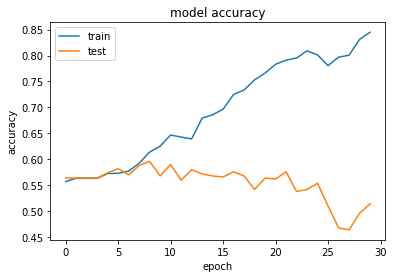

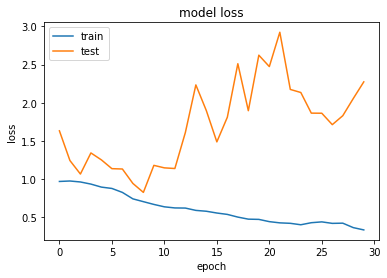

<Figure size 432x288 with 0 Axes>

In [0]:
plotMetricsGraph(history_cnn_f, model_name)

##### RNN Model

Using Glove Embeddings

In [0]:
model_rnn_g = RNNModel(word_index_g, embedding_dim, word_embedding_matrix_g, max_seq_length, p_drop=0.25)
model_rnn_g.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_9_input (InputLayer)  (None, 30)           0                                            
__________________________________________________________________________________________________
embedding_10_input (InputLayer) (None, 30)           0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 30, 300)      655500      embedding_9_input[0][0]          
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 30, 300)      655500      embedding_10_input[0][0]         
____________________________________________________________________________________________

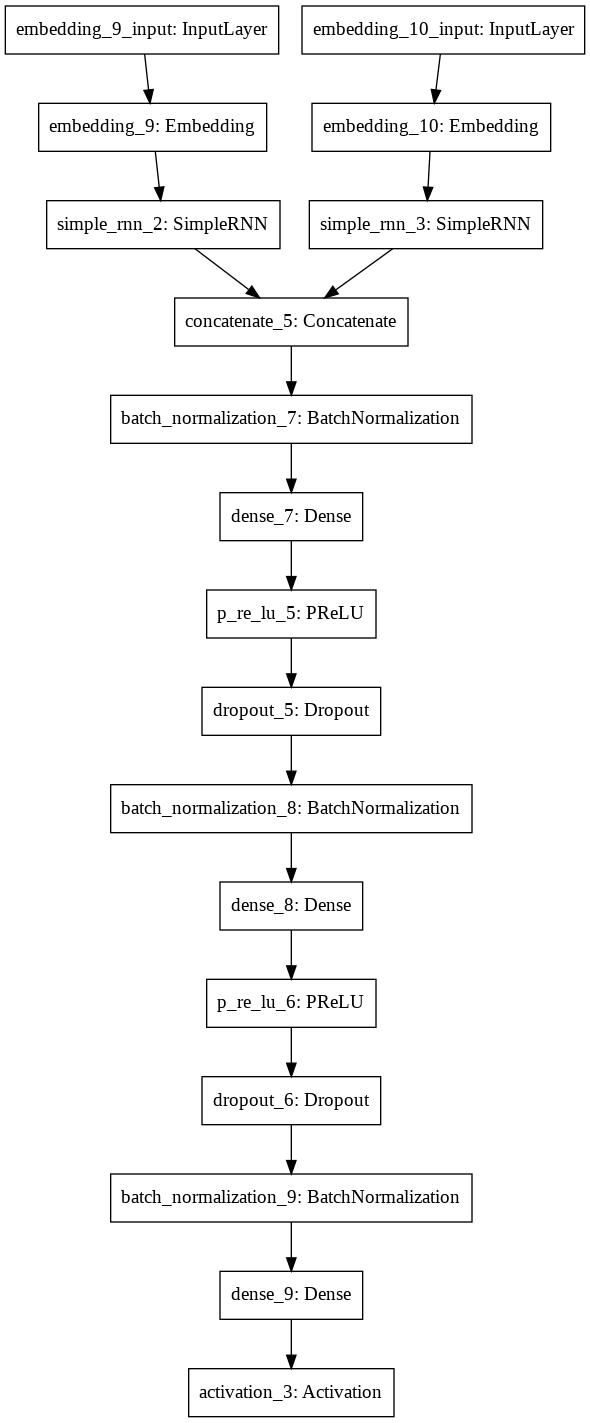

In [0]:
model_name = 'RNN_Glove'
plotModelPicture(model_rnn_g, model_name)
Image(filename = outputPath+'/'+model_name + '-model.png')

In [0]:
history_rnn_g = trainModel(model_rnn_g, model_name, s1_data_g, s2_data_g, train_labels, batch_size, s1_dataValid_g, s2_dataValid_g, valid_labels)

Train on 4500 samples, validate on 500 samples
Epoch 1/30
 - 14s - loss: 1.4975 - acc: 0.4853 - val_loss: 1.4649 - val_acc: 0.5540
Epoch 2/30
 - 10s - loss: 1.0023 - acc: 0.5456 - val_loss: 1.1334 - val_acc: 0.5580
Epoch 3/30
 - 10s - loss: 0.9744 - acc: 0.5524 - val_loss: 1.2702 - val_acc: 0.5640
Epoch 4/30
 - 10s - loss: 0.9848 - acc: 0.5418 - val_loss: 1.6691 - val_acc: 0.5640
Epoch 5/30
 - 10s - loss: 0.9895 - acc: 0.5589 - val_loss: 1.9046 - val_acc: 0.5640
Epoch 6/30
 - 10s - loss: 0.9920 - acc: 0.5587 - val_loss: 1.8622 - val_acc: 0.5640
Epoch 7/30
 - 10s - loss: 0.9906 - acc: 0.5627 - val_loss: 2.5524 - val_acc: 0.5640
Epoch 8/30
 - 10s - loss: 0.9823 - acc: 0.5640 - val_loss: 2.6011 - val_acc: 0.5640
Epoch 9/30
 - 10s - loss: 0.9890 - acc: 0.5702 - val_loss: 2.2537 - val_acc: 0.5640
Epoch 10/30
 - 10s - loss: 0.9712 - acc: 0.5827 - val_loss: 2.4742 - val_acc: 0.5640
Epoch 11/30
 - 10s - loss: 0.9726 - acc: 0.5889 - val_loss: 2.6312 - val_acc: 0.5640
Epoch 12/30
 - 10s - loss: 

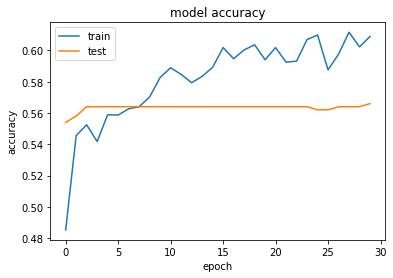

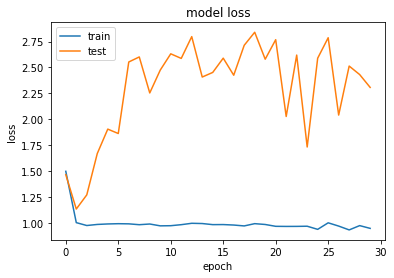

<Figure size 432x288 with 0 Axes>

In [0]:
plotMetricsGraph(history_rnn_g, model_name)

Using Fasttext Embeddings

In [0]:
#word_index_f, embedding_dim, word_embedding_matrix_f, max_seq_length, 
model_rnn_f = RNNModel(word_index_f, embedding_dim, word_embedding_matrix_f, max_seq_length, p_drop=0.25)
model_rnn_f.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_11_input (InputLayer) (None, 30)           0                                            
__________________________________________________________________________________________________
embedding_12_input (InputLayer) (None, 30)           0                                            
__________________________________________________________________________________________________
embedding_11 (Embedding)        (None, 30, 300)      655500      embedding_11_input[0][0]         
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 30, 300)      655500      embedding_12_input[0][0]         
____________________________________________________________________________________________

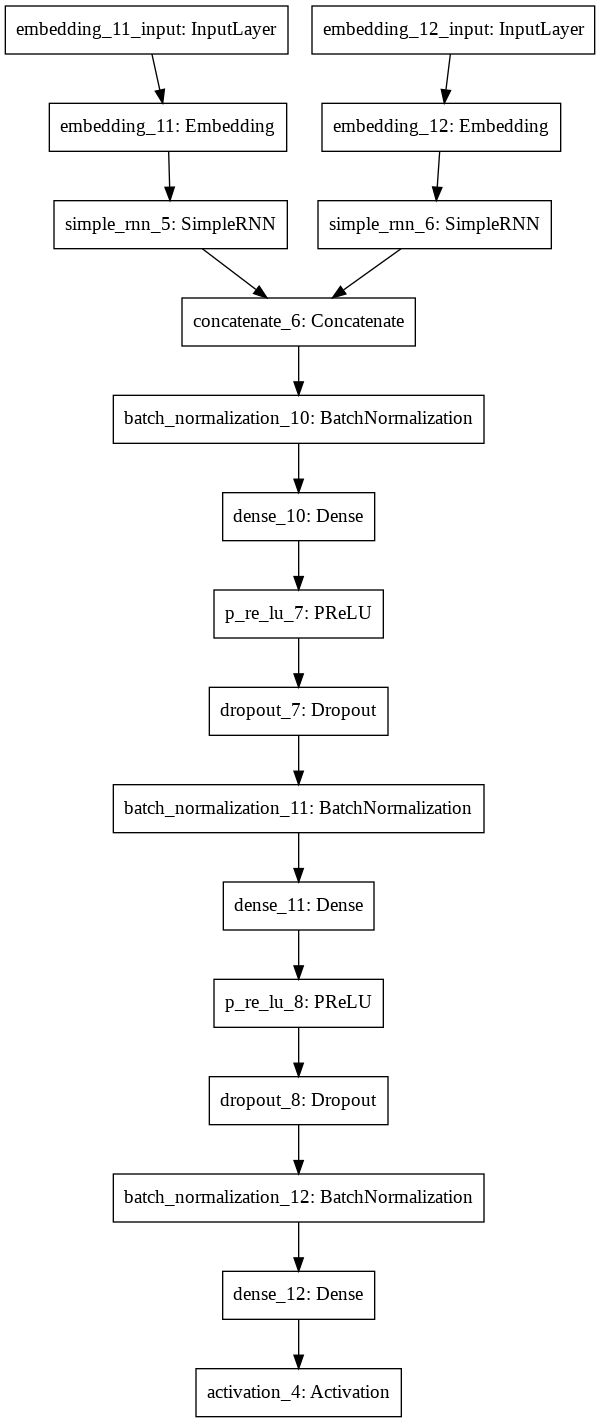

In [0]:
model_name = 'RNN_Fasttext'
plotModelPicture(model_rnn_f, model_name)
Image(filename = outputPath+'/'+model_name + '-model.png')

In [0]:
history_rnn_f = trainModel(model_rnn_f, model_name, s1_data_f, s2_data_f, train_labels, batch_size, s1_dataValid_f, s2_dataValid_f, valid_labels)

Train on 4500 samples, validate on 500 samples
Epoch 1/30
 - 14s - loss: 1.5762 - acc: 0.4949 - val_loss: 1.3464 - val_acc: 0.5640
Epoch 2/30
 - 10s - loss: 0.9831 - acc: 0.5551 - val_loss: 1.1910 - val_acc: 0.5640
Epoch 3/30
 - 10s - loss: 0.9777 - acc: 0.5464 - val_loss: 1.4448 - val_acc: 0.5640
Epoch 4/30
 - 10s - loss: 0.9885 - acc: 0.5531 - val_loss: 1.5895 - val_acc: 0.5660
Epoch 5/30
 - 10s - loss: 0.9797 - acc: 0.5576 - val_loss: 1.9134 - val_acc: 0.5640
Epoch 6/30
 - 10s - loss: 0.9775 - acc: 0.5642 - val_loss: 2.4650 - val_acc: 0.5640
Epoch 7/30
 - 10s - loss: 0.9825 - acc: 0.5620 - val_loss: 1.9661 - val_acc: 0.5640
Epoch 8/30
 - 10s - loss: 0.9784 - acc: 0.5727 - val_loss: 1.7037 - val_acc: 0.5520
Epoch 9/30
 - 10s - loss: 0.9809 - acc: 0.5751 - val_loss: 2.5561 - val_acc: 0.5640
Epoch 10/30
 - 10s - loss: 0.9916 - acc: 0.5764 - val_loss: 2.3635 - val_acc: 0.5640
Epoch 11/30
 - 10s - loss: 0.9776 - acc: 0.5856 - val_loss: 1.9197 - val_acc: 0.5620
Epoch 12/30
 - 10s - loss: 

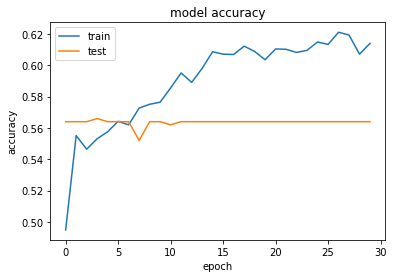

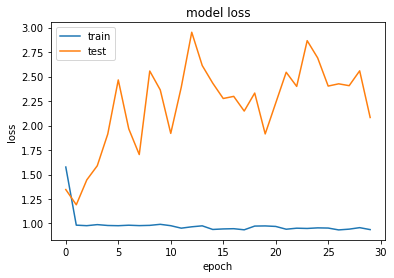

<Figure size 432x288 with 0 Axes>

In [0]:
plotMetricsGraph(history_rnn_f, model_name)

### Model Evaluation

In [0]:
#model = model_lstm

In [0]:
def getTestDataSequences(tokenizer):
  test_s1_word_sequences = tokenizer.texts_to_sequences(test_data['sentence_A'].values.tolist())
  test_s2_word_sequences = tokenizer.texts_to_sequences(test_data['sentence_B'].values.tolist())

  test_s1_data = pad_sequences(test_s1_word_sequences, maxlen = max_seq_length)
  test_s2_data = pad_sequences(test_s2_word_sequences, maxlen = max_seq_length)
  test_labels = np_utils.to_categorical(le.fit_transform(test_data["entailment_judgment"].values)).astype("int64")

  print('Shape of test sentence1 tensor:', test_s1_data.shape)
  print('Shape of test sentence2 tensor:', test_s2_data.shape)
  print('Shape of test label tensor:', test_labels.shape)
  return test_s1_data, test_s2_data, test_labels

In [0]:
def evaluateModel(model, test_s1_data, test_s2_data, test_labels):
  loss, accuracy = model.evaluate([test_s1_data, test_s2_data], test_labels)
  print('loss     = ', loss)
  print('accuracy = ', accuracy)

In [0]:
test_s1_data_g, test_s2_data_g, test_labels_g = getTestDataSequences(tokenizer_g)

Shape of test sentence1 tensor: (4927, 30)
Shape of test sentence2 tensor: (4927, 30)
Shape of test label tensor: (4927, 3)


In [0]:
test_s1_data_f, test_s2_data_f, test_labels_f = getTestDataSequences(tokenizer_f)

Shape of test sentence1 tensor: (4927, 30)
Shape of test sentence2 tensor: (4927, 30)
Shape of test label tensor: (4927, 3)


In [0]:
#test_s1_word_sequences = tokenizer_f.texts_to_sequences(test_data['sentence_A'].values.tolist())
#test_s2_word_sequences = tokenizer_f.texts_to_sequences(test_data['sentence_B'].values.tolist())

#test_s1_data = pad_sequences(test_s1_word_sequences, maxlen = max_seq_length)
#test_s2_data = pad_sequences(test_s2_word_sequences, maxlen = max_seq_length)
#test_labels = np_utils.to_categorical(le.fit_transform(test_data["entailment_judgment"].values)).astype("int64")

#print('Shape of test sentence1 tensor:', test_s1_data.shape)
#print('Shape of test sentence2 tensor:', test_s2_data.shape)
#print('Shape of test label tensor:', test_labels.shape)

In [0]:
#LSTM - Glove
evaluateModel(model_lstm_g, test_s1_data_g, test_s2_data_g, test_labels_g)

4927/4927 [==============================] - 8s 2ms/step
loss     =  0.17511322814838892
accuracy =  0.6354779785100891


In [0]:
#CNN - Glove
evaluateModel(model_cnn_g, test_s1_data_g, test_s2_data_g, test_labels_g)

4927/4927 [==============================] - 2s 328us/step
loss     =  2.3365291988532686
accuracy =  0.5311548610548473


In [0]:
#RNN - Glove
evaluateModel(model_rnn_g, test_s1_data_g, test_s2_data_g, test_labels_g)

4927/4927 [==============================] - 3s 536us/step
loss     =  2.256826857948891
accuracy =  0.5668763953724376


In [0]:
#LSTM - Fasttext
evaluateModel(model_lstm_f, test_s1_data_f, test_s2_data_f, test_labels_f)

4927/4927 [==============================] - 7s 1ms/step
loss     =  0.1820727651789467
accuracy =  0.5892023543738584


In [0]:
#CNN - Fasttext
evaluateModel(model_cnn_f, test_s1_data_f, test_s2_data_f, test_labels_f)

4927/4927 [==============================] - 2s 328us/step
loss     =  2.174427174520173
accuracy =  0.5291252282368912


In [0]:
#RNN - Fasttext
evaluateModel(model_rnn_f, test_s1_data_f, test_s2_data_f, test_labels_f)

4927/4927 [==============================] - 3s 530us/step
loss     =  2.1130462384820348
accuracy =  0.5668763953724376


In [0]:
#loss, accuracy = model.evaluate([test_s1_data, test_s2_data], test_labels)
#print('loss     = ', loss)
#print('accuracy = ', accuracy)

Best model performed is LSTM encoded with Glove

In [0]:
model = model_lstm_g

In [0]:
test_pred = model.predict([test_s1_data_g, test_s2_data_g], batch_size=32)

In [0]:
output = list()
output_score = list()
for x in test_pred:
  #print(type(x))
  output_score.append(np.amax(x))
  output.append(["CONTRADICTION", "ENTAILMENT", "NEUTRAL"][np.argmax(x)])

test_data["Actual Output"] = output
test_data["Predicted Score"] = output_score

test_data.to_excel(outputPath+'/output_lstm_glove.xlsx')

In [0]:
from sklearn.metrics import classification_report

predicted = np.argmax(test_pred, axis=1)
report = classification_report(test_data["entailment_judgment"], test_data["Actual Output"])
print(report)

               precision    recall  f1-score   support

CONTRADICTION       0.77      0.61      0.68       720
   ENTAILMENT       0.55      0.29      0.38      1414
      NEUTRAL       0.66      0.85      0.74      2793

     accuracy                           0.65      4927
    macro avg       0.66      0.58      0.60      4927
 weighted avg       0.64      0.65      0.63      4927



## Task 2 Semantic Relatedness

##### Normalizing scores

In [0]:
train_labels = train_data["relatedness_score"]
valid_labels = valid_data["relatedness_score"]
test_labels = test_data["relatedness_score"]

In [0]:
train_labels

0       4.5
1       3.2
2       4.7
3       3.4
4       3.7
       ... 
4495    1.1
4496    1.0
4497    1.0
4498    1.2
4499    1.0
Name: relatedness_score, Length: 4500, dtype: float64

In [0]:
train_sent1, train_sent2, valid_sent1, valid_sent2 = convertSentencesToList(train_data, valid_data)

In [0]:
train_labels.shape

(4500,)

In [0]:
from sklearn.preprocessing import MinMaxScaler

x = np.array(train_labels)
q = np.reshape(x, (-1,1))
scaler = MinMaxScaler()
scaler.fit(q)
train_labels = pd.DataFrame(scaler.transform(q))

y = np.array(valid_labels)
w = np.reshape(y, (-1,1))
scaler1 = MinMaxScaler()
scaler1.fit(w)
valid_labels = pd.DataFrame(scaler1.transform(w))

In [0]:
glove_length = len(glove_embeddings)
fasttext_length = len(fasttext_embeddings)

print('Found '+ str(len(train_sent1)) + ' in training sentence 1')
#print('Found '+ str(len(train_sent2)) + ' in training sentence 2')

training_sent = train_sent1 + train_sent2
valid_sent = valid_sent1 + valid_sent2

tokenizer_g, t_s1_word_sequences_g, t_s2_word_sequences_g, v_s1_word_sequences_g, v_s2_word_sequences_g = converToWordSequences(glove_length, training_sent, train_sent1, train_sent2, valid_sent1, valid_sent2)
tokenizer_f, t_s1_word_sequences_f, t_s2_word_sequences_f, v_s1_word_sequences_f, v_s2_word_sequences_f = converToWordSequences(fasttext_length, training_sent, train_sent1, train_sent2, valid_sent1, valid_sent2)
word_index_g = tokenizer_g.word_index
word_index_f = tokenizer_f.word_index

print('Found '+str(len(word_index_g))+' unique tokens for glove sequencing.')
print('Found '+str(len(word_index_f))+' unique tokens for fasttext sequencing.')

Found 4500 in training sentence 1
Found 2184 unique tokens for glove sequencing.
Found 2184 unique tokens for fasttext sequencing.


In [0]:
text_count_g, hypo_count_g, word_embedding_matrix_g = useWordEmbeddings(word_index_g, glove_length, glove_embeddings, t_s1_word_sequences_g, t_s2_word_sequences_g)
text_count_f, hypo_count_f, word_embedding_matrix_f = useWordEmbeddings(word_index_f, fasttext_length, fasttext_embeddings, t_s1_word_sequences_f, t_s2_word_sequences_f)

In [0]:
s1_data_g, s2_data_g, s1_dataValid_g, s2_dataValid_g = convertToPadSequences(t_s1_word_sequences_g, t_s2_word_sequences_g, v_s1_word_sequences_g, v_s2_word_sequences_g, max_seq_length)

In [0]:
print('Shape of sentence1 tensor:', s1_data_g.shape)
print('Shape of sentence2 tensor:', s2_data_g.shape)
print('Shape of label tensor:', train_labels.shape)

Shape of sentence1 tensor: (4500, 30)
Shape of sentence2 tensor: (4500, 30)
Shape of label tensor: (4500, 1)


In [0]:
def LSTMModelSemantic(word_index, EMBEDDING_DIM, embedding_matrix, MAX_SEQUENCE_LENGTH, p_drop=0.0):
  
    lstm_layer = LSTM(num_lstm, dropout=rate_drop_lstm, recurrent_dropout=rate_drop_lstm)

  
    encoder_1 = Sequential()
    encoder_1.add(Embedding(len(word_index) + 1, EMBEDDING_DIM,
                                    embeddings_initializer=Constant(embedding_matrix),
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=False))

    encoder_1.add(lstm_layer)

    encoder_2 = Sequential()
    encoder_2.add(Embedding(len(word_index) + 1, EMBEDDING_DIM,
                                    embeddings_initializer=Constant(embedding_matrix),
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=False))

    encoder_2.add(lstm_layer)

    

    merged_layers = concatenate([encoder_1.output, encoder_2.output])
    
    x = BatchNormalization()(merged_layers)
    x = Dense(EMBEDDING_DIM)(x)
    x = PReLU()(x)
    x = Dropout(p_drop)(x)
    x = BatchNormalization()(x)
    x = Dense(EMBEDDING_DIM)(x)
    x = PReLU()(x)
    x = Dropout(p_drop)(x)
    x = BatchNormalization()(x)
    x = Dense(1)(x)

    out = Activation('sigmoid')(x)
    merged_model = Model([encoder_1.input, encoder_2.input], [out])
    merged_model.compile(loss = 'mean_squared_error', optimizer=Adam(lr=0.01), metrics = ['mse'])
    
    return merged_model

In [0]:
def trainModelSemantic(model, model_name, s1_data, s2_data, labels, batch_size, s1_data_valid, s2_data_valid, labels_valid):
  checkpoint = ModelCheckpoint(model_name + '-checkpoint-weights.{epoch:02d}-{val_mean_squared_error:.2f}.hdf5', monitor='val_mean_squared_error', save_best_only=True)
  history = model.fit([s1_data, s2_data],
                        labels,
                        epochs = 20,
                        batch_size = batch_size,
                        validation_data=([s1_data_valid, s2_data_valid], labels_valid),
                        shuffle = True,
                        verbose = 2,
                        callbacks = [checkpoint])
  return history

In [0]:
model_lstm_semantic = LSTMModelSemantic(word_index_g, embedding_dim, word_embedding_matrix_g, max_seq_length, p_drop=0.25)

In [0]:
model_name = 'LSTM_semantic'
history_lstm = trainModelSemantic(model_lstm_semantic, model_name, s1_data_g, s2_data_g, train_labels, batch_size, s1_dataValid_g, s2_dataValid_g, valid_labels)

Train on 4500 samples, validate on 500 samples
Epoch 1/20
 - 32s - loss: 0.1118 - mean_squared_error: 0.1118 - val_loss: 0.0794 - val_mean_squared_error: 0.0794
Epoch 2/20
 - 29s - loss: 0.0693 - mean_squared_error: 0.0693 - val_loss: 0.0666 - val_mean_squared_error: 0.0666
Epoch 3/20
 - 29s - loss: 0.0623 - mean_squared_error: 0.0623 - val_loss: 0.0660 - val_mean_squared_error: 0.0660
Epoch 4/20
 - 29s - loss: 0.0561 - mean_squared_error: 0.0561 - val_loss: 0.0550 - val_mean_squared_error: 0.0550
Epoch 5/20
 - 29s - loss: 0.0528 - mean_squared_error: 0.0528 - val_loss: 0.0502 - val_mean_squared_error: 0.0502
Epoch 6/20
 - 29s - loss: 0.0501 - mean_squared_error: 0.0501 - val_loss: 0.0544 - val_mean_squared_error: 0.0544
Epoch 7/20
 - 29s - loss: 0.0489 - mean_squared_error: 0.0489 - val_loss: 0.0499 - val_mean_squared_error: 0.0499
Epoch 8/20
 - 29s - loss: 0.0443 - mean_squared_error: 0.0443 - val_loss: 0.0477 - val_mean_squared_error: 0.0477
Epoch 9/20
 - 28s - loss: 0.0425 - mean_s

In [0]:
test_s1_word_sequences = tokenizer_g.texts_to_sequences(test_data['sentence_A'].values.tolist())
test_s2_word_sequences = tokenizer_g.texts_to_sequences(test_data['sentence_B'].values.tolist())

test_s1_data = pad_sequences(test_s1_word_sequences, maxlen = max_seq_length)
test_s2_data = pad_sequences(test_s2_word_sequences, maxlen = max_seq_length)
test_labels = test_data["relatedness_score"]

print('Shape of test sentence1 tensor:', test_s1_data.shape)
print('Shape of test sentence2 tensor:', test_s2_data.shape)
print('Shape of test label tensor:', test_labels.shape)

Shape of test sentence1 tensor: (4927, 30)
Shape of test sentence2 tensor: (4927, 30)
Shape of test label tensor: (4927,)


In [0]:
e = np.reshape(np.array(test_labels), (-1,1))
scaler1 = MinMaxScaler()
scaler1.fit(e)
test_labels = pd.DataFrame(scaler1.transform(e))

In [0]:
test_pred = model_lstm_semantic.predict([test_s1_data, test_s2_data], batch_size=128)

In [0]:
output= list()
for x in test_pred:
  output.append(x[0])

test_data["Actual Output"] = output
test_data["normalized label"] = test_labels
test_data.to_excel(outputPath+'/'+'output_semantic.xlsx')

In [0]:
import numpy
numpy.corrcoef(test_data['normalized label'], test_data['Actual Output'])[0, 1]

0.6084204207862924

In [0]:
from numpy.random import rand
from numpy.random import seed
from scipy.stats import spearmanr
# seed random number generator
seed(1)

# calculate spearman's correlation
coef, p = spearmanr(test_data['normalized label'], test_data['Actual Output'])
print('Spearmans correlation coefficient: %.3f' % coef)
print('p: %.3f' % p)

Spearmans correlation coefficient: 0.471
p: 0.000


In [0]:
output = np.reshape(np.array(test_data['Actual Output']), (-1,1))

scaler = MinMaxScaler(feature_range=(1, 5))
scaler.fit(output)
out = pd.DataFrame(scaler.transform(output))

In [0]:
out

,0
0,3.502983
1,4.243102
2,4.340876
3,4.306273
4,4.274955
...,...
4922,1.469733
4923,2.159707
4924,1.206841
4925,2.187893


In [0]:
test_data["Actual Output"] = output
test_data["normalized label"] = test_labels
test_data["Relatedness_score"] = out
test_data.to_excel(outputPath+'/'+'output_semantic.xlsx')